<a href="https://colab.research.google.com/github/amit-420/robotic_arm/blob/main/Inverse_Kinematics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [1]:

from __future__ import division
import numpy as np
import sympy as sp
import math as m
import matplotlib as mpl
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import time
%matplotlib notebook
class DH:
    @staticmethod
    def num_para(theta1,theta2,theta3,theta4):
        link0,link1,link2,link3 = 0,0,4,4
        theta1,theta2,theta3,theta4 = m.radians(theta1),m.radians(theta2),m.radians(theta3),m.radians(theta4)
        DHpara = np.array([[0,  link0, theta1, 4],
                        [m.pi/2,link1,theta2,0],
                        [0,link2,theta3, 0],
                        [-m.pi/2,link3,theta4,0],
                    ])
        return DHpara
    @staticmethod
    def sp_para():
        link0,link1,link2,link3 = 0,0,4,4
        theta1,theta2,theta3,theta4 = sp.symbols("theta1,theta2,theta3,theta4")
        DHpara = np.array([[0,  link0, theta1, 4],
                        [sp.pi/2,link1,theta2,0],
                        [0,link2,theta3, 0],
                        [-sp.pi/2,link3,theta4,0],
                    ])
        return DHpara
 
 
 
class Transform:
    def __init__(self, DHpara):
        self.a = DHpara[0]
        self.L = DHpara[1]
        self.t = DHpara[2]
        self.d = DHpara[3]
    def np_transform(self):
        T = np.array([[np.cos(self.t),-np.sin(self.t),0,self.L],
                [np.sin(self.t)*np.cos(self.a),np.cos(self.t)*np.cos(self.a),-np.sin(self.a),-np.sin(self.a)*self.d],
                [np.sin(self.t)*np.sin(self.a),np.cos(self.t)*np.sin(self.a),np.cos(self.a),np.cos(self.a)*self.d],
                [0,0,0,1]])
        return T
    @staticmethod
    def sp_transform(DH):
        alpha, L, theta,d = DH[0], DH[1], DH[2], DH[3] 
        T = sp.Matrix([[sp.cos(theta),-sp.sin(theta),0,L],
                [sp.sin(theta)*sp.cos(alpha),sp.cos(theta)*sp.cos(alpha),-sp.sin(alpha),-sp.sin(alpha)*d],
                [sp.sin(theta)*sp.sin(alpha),sp.cos(theta)*sp.sin(alpha),sp.cos(alpha),sp.cos(alpha)*d],
                [0,0,0,1]])
        return T
 
def transf_wrt_origin(theta1,theta2,theta3,theta4):
    DHpara = DH.num_para(theta1,theta2,theta3,theta4)
    z = np.identity(4)
    for i in range(len(DHpara)):
        T = Transform(DHpara[i])
        X = T.np_transform()
        z = np.dot(z,X)
        record[i] = z
    return record
 
 
def sp_jacobian():
    para = DH.sp_para()
    z = sp.eye(4)
    joint_po = sp.eye(4,1)
    theta1,theta2,theta3,theta4 = sp.symbols("theta1,theta2,theta3,theta4")
    for i in range(0,len(para)):
        T = Transform.sp_transform(para[i])
        z = z@T
        joint_po = joint_po.col_insert(i,z.col(3))
    colm1 = sp.diff(z.col(3),theta1)
    colm2 = sp.diff(z.col(3),theta2)
    colm3 = sp.diff(z.col(3),theta3)
    colm4 = sp.diff(z.col(3),theta4)
    Jv = sp.Matrix([colm1])
    Jv = Jv.col_insert(1,sp.Matrix([colm2]))
    Jv = Jv.col_insert(2,sp.Matrix([colm3]))
 
    Jv.row_del(3)
    joint_po.row_del(3)
    return Jv, z, joint_po
 
Jv ,z,joint_po = sp_jacobian()

sp.init_printing()
Jv

⎡4⋅sin(θ₁)⋅sin(θ₂)⋅sin(θ₃) - 4⋅sin(θ₁)⋅cos(θ₂)⋅cos(θ₃) - 4⋅sin(θ₁)⋅cos(θ₂)   -
⎢                                                                             
⎢-4⋅sin(θ₂)⋅sin(θ₃)⋅cos(θ₁) + 4⋅cos(θ₁)⋅cos(θ₂)⋅cos(θ₃) + 4⋅cos(θ₁)⋅cos(θ₂)  -
⎢                                                                             
⎣                                    0                                        

4⋅sin(θ₂)⋅cos(θ₁)⋅cos(θ₃) - 4⋅sin(θ₂)⋅cos(θ₁) - 4⋅sin(θ₃)⋅cos(θ₁)⋅cos(θ₂)  -4⋅
                                                                              
4⋅sin(θ₁)⋅sin(θ₂)⋅cos(θ₃) - 4⋅sin(θ₁)⋅sin(θ₂) - 4⋅sin(θ₁)⋅sin(θ₃)⋅cos(θ₂)  -4⋅
                                                                              
           -4⋅sin(θ₂)⋅sin(θ₃) + 4⋅cos(θ₂)⋅cos(θ₃) + 4⋅cos(θ₂)                 

sin(θ₂)⋅cos(θ₁)⋅cos(θ₃) - 4⋅sin(θ₃)⋅cos(θ₁)⋅cos(θ₂)⎤
                                                   ⎥
sin(θ₁)⋅sin(θ₂)⋅cos(θ₃) - 4⋅sin(θ₁)⋅sin(θ₃)⋅cos(θ₂)⎥
                                                 

In [2]:
p_1 = joint_po.col(0)
p_2 = joint_po.col(1)
p_3 = joint_po.col(2)
p_4 = joint_po.col(3)

p_1,p_2,p_3,p_4

⎛⎡0⎤  ⎡0⎤  ⎡4⋅cos(θ₁)⋅cos(θ₂)⎤  ⎡-4⋅sin(θ₂)⋅sin(θ₃)⋅cos(θ₁) + 4⋅cos(θ₁)⋅cos(θ₂
⎜⎢ ⎥  ⎢ ⎥  ⎢                 ⎥  ⎢                                             
⎜⎢0⎥, ⎢0⎥, ⎢4⋅sin(θ₁)⋅cos(θ₂)⎥, ⎢-4⋅sin(θ₁)⋅sin(θ₂)⋅sin(θ₃) + 4⋅sin(θ₁)⋅cos(θ₂
⎜⎢ ⎥  ⎢ ⎥  ⎢                 ⎥  ⎢                                             
⎝⎣4⎦  ⎣4⎦  ⎣  4⋅sin(θ₂) + 4  ⎦  ⎣          4⋅sin(θ₂)⋅cos(θ₃) + 4⋅sin(θ₂) + 4⋅s

)⋅cos(θ₃) + 4⋅cos(θ₁)⋅cos(θ₂)⎤⎞
                             ⎥⎟
)⋅cos(θ₃) + 4⋅sin(θ₁)⋅cos(θ₂)⎥⎟
                             ⎥⎟
in(θ₃)⋅cos(θ₂) + 4           ⎦⎠

In [3]:
theta1,theta2,theta3,theta4 = sp.symbols("theta1,theta2,theta3,theta4")
expr1 = p_1
expr2 = p_2
expr3 = p_3
expr4 = p_4
expr5 = Jv

np_p_1 = sp.lambdify((theta1,theta2,theta3), expr1, 'numpy')
np_p_2 = sp.lambdify((theta1,theta2,theta3), expr2, 'numpy')
np_p_3 = sp.lambdify((theta1,theta2,theta3), expr3, 'numpy')
np_p_4 = sp.lambdify((theta1,theta2,theta3), expr4, 'numpy')
jacobian = sp.lambdify((theta1,theta2,theta3), expr5, 'numpy')
 
# print(xp(np.pi/3,np.pi/6,np.pi/4,1))
# print(np.linalg.pinv(jacobian(np.pi/3,np.pi/6,np.pi/6,0)))
qo = np.array([0,0,np.pi/2])
def func(qo,np_p_4):
    o1,o2,o3 = qo[0],qo[1],qo[2]
    func = np.subtract(np_p_4(o1,o2,o3).T ,np.array([6,4,4]))
    return func.ravel()

def tan(np_p_4,jacobian,qo):
    o1,o2,o3, = qo[0],qo[1],qo[2]

    q = qo - (np.linalg.inv(jacobian(o1,o2,o3)) @ func(qo,np_p_4))

    return q

record = qo
y = func(qo,np_p_4)
q = tan(np_p_4,jacobian,qo)
record = np.vstack((record,q))
iteration = 1


while np.absolute(y[0]) > 10e-6 or np.absolute(y[1]) > 10e-6 or np.absolute(y[2]) > 10e-6:
    q = tan(np_p_4,jacobian,q)
    y = func(q,np_p_4)
    iteration += 1
    print(q)
    record = np.vstack((record,q))
    
    
# print(q)
# print(y)
print(iteration)
print(record)
print(np.shape(record))

[ 0.29206192 -0.690741    1.33768647]
[ 0.62721851 -0.54176317  1.08785792]
[ 0.5859184  -0.45706614  0.91390443]
[ 0.58801186 -0.44792105  0.89584311]
[ 0.5880026  -0.44783241  0.89566481]
6
[[ 0.          0.          1.57079633]
 [ 1.         -1.          2.07079633]
 [ 0.29206192 -0.690741    1.33768647]
 [ 0.62721851 -0.54176317  1.08785792]
 [ 0.5859184  -0.45706614  0.91390443]
 [ 0.58801186 -0.44792105  0.89584311]
 [ 0.5880026  -0.44783241  0.89566481]]
(7, 3)


In [4]:
theta1,theta2,theta3 = q[0],q[1],q[2]
print(np_p_1(theta1,theta2,theta3))
print(np_p_2(theta1,theta2,theta3))
print(np_p_3(theta1,theta2,theta3))
np_p_4(theta1,theta2,theta3)

[[0]
 [0]
 [4]]
[[0]
 [0]
 [4]]
[[2.99999999]
 [1.99999999]
 [2.26794916]]


array([[5.99999998],
       [3.99999998],
       [4.        ]])

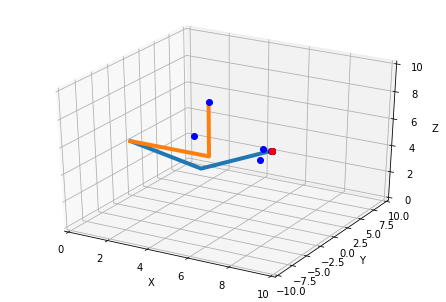

In [8]:
def run_animation(np_p_1,np_p_2,np_p_3,np_p_4,record):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_xlim3d([0,10.0])
    ax.set_xlabel('X')
    ax.set_ylim3d([-10,10])
    ax.set_ylabel('Y')
    ax.set_zlim3d([0,10])
    ax.set_zlabel('Z')

    line, = ax.plot([],[],[], lw = 4)
    line1, = ax.plot([],[],[], lw = 4)
    
    
    def init():
        o1,o2,o3 = record[0][0],record[0][1],record[0][2]
        ax.plot([6],[4],[4],'ro')
        # line.set_data([0],[0])
        # line.set_3d_properties([0])
        line1.set_data([0,np_p_3(o1,o2,o3)[0],np_p_4(o1,o2,o3)[0]],
                      [0,np_p_3(o1,o2,o3)[1],np_p_4(o1,o2,o3)[1]])
        line1.set_3d_properties([4,np_p_3(o1,o2,o3)[2],np_p_4(o1,o2,o3)[2]])
        return line, line1,
    
    def animate(i):
        o1,o2,o3 = record[i][0],record[i][1],record[i][2]
        
        ax.plot([6],[4],[4],'ro')
        
        ax.plot(np_p_4(o1,o2,o3)[0],np_p_4(o1,o2,o3)[1],np_p_4(o1,o2,o3)[2],'bo')
        
        line.set_data([0,np_p_3(o1,o2,o3)[0],np_p_4(o1,o2,o3)[0]],
                      [0,np_p_3(o1,o2,o3)[1],np_p_4(o1,o2,o3)[1]])
        line.set_3d_properties([4,np_p_3(o1,o2,o3)[2],np_p_4(o1,o2,o3)[2]])
        return line,

    anim = animation.FuncAnimation(fig,animate, init_func = init,frames = len(record),interval = 10,blit = False)
    anim.save('inverse_kinematics.mp4',writer = 'ffmpeg', fps = 1)
    plt.show()

run_animation(np_p_1,np_p_2,np_p_3,np_p_4,record)




---


Only for reference 




In [9]:
def transf_wrt_origin(q):
    theta1,theta2,theta3 = q[0],q[1],q[2]
    DHpara = DH.num_para(theta1,theta2,theta3,theta4=0)
    z = np.identity(4)
    record = np.zeros((4,4,4))
    for i in range(0,len(DHpara)):
        T = Transform(DHpara[i])
        X = T.np_transform()
        z = z@X
        record[i] = z
    return record

record = transf_wrt_origin(q)
print(record)

[[[ 9.99947340e-01 -1.02624013e-02  0.00000000e+00  0.00000000e+00]
  [ 1.02624013e-02  9.99947340e-01  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  4.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99916796e-01  7.81565879e-03  1.02624013e-02  0.00000000e+00]
  [ 1.02620878e-02  8.02116508e-05 -9.99947340e-01  0.00000000e+00]
  [-7.81607039e-03  9.99969454e-01  6.12323400e-17  4.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99916796e-01 -7.81565879e-03  1.02624013e-02  3.99966718e+00]
  [ 1.02620878e-02 -8.02116508e-05 -9.99947340e-01  4.10483513e-02]
  [ 7.81607039e-03  9.99969454e-01  6.12323400e-17  3.96873572e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99916796e-01 -1.02624013e-02 -7.81565879e-03  7.99933437e+00]
  [ 1.02620878e-02  9.99947340e-01 -8.02116508e-05  8.20967025e-02]
  [ 7.81607039e-03 -1.87039967e-21  9.9996




---


#### Reference links
* sympy matrix [multiplication](https://docs.sympy.org/latest/tutorial/matrices.html)
* lambdify converting multi variable function [link](https://docs.sympy.org/latest/modules/utilities/lambdify.html)
* Newton raphson method for multivariate [link](http://fourier.eng.hmc.edu/e176/lectures/NM/node21.html)


In [ ]:
from sympy import sin, cos, symbols, lambdify
 
import numpy as np
 
x ,y = symbols('x,y')
 
expr = sin(x) + sin(y)
 
f = lambdify([x,y], expr, 'numpy')
 
a = np.array([np.pi/2])
 
 
print(f(a,a))

In [ ]:
a = np.asarray([2,2,3])
b = np.asarray([-1,0,1])
c = np.asarray([True, False])

print(True or False or False)
print(a.all())

print(b.any())
print(b.all())

print(c.any())
print(c.all())